# new agent dynamics with ease-out speed and sinusoid noise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from scipy.stats import multivariate_normal
from scipy.special import logsumexp
import matplotlib.animation as animation

from matplotlib.gridspec import GridSpec
import warnings
import os
from PIL import Image
import fitz
from pathlib import Path

warnings.filterwarnings('ignore')

class MultiModeAgent:
    """
    Modes:
    - 'line':   Closed-loop dynamics from Eq. (12):  xdot = -λ(θ)(x - x(θ)) + d(t)
    - 'sinusoid' and 'curve': unchanged time-parametrized reference paths
    """

    def __init__(self,
                 theta_com: np.ndarray,   # [x_goal, y_goal, r_goal, t_goal]
                 x0: np.ndarray,          # Initial position
                 mode: str = 'line',
                 d_bar: float = 0.2,      # Disturbance bound (amplitude)
                 dt: float = 0.1,         # Time step

                 amplitude: float = 3.0,
                 frequency: float = 2.0,
                 ease_k: float = 2.0,

                 # noise
                 noise_type: str = 'sinusoid',
                 noise_frequency: float = 1.0,
                 noise_phase: float = 0.0,

                 enforce_terminal: bool = True,
                 lambda_theta: float = None
                 ):

        self.theta_com = theta_com.astype(float)
        self.x_goal = self.theta_com[:2]
        self.r_goal = float(self.theta_com[2])
        self.t_goal = float(self.theta_com[3])

        self.x0 = x0.astype(float)
        self.mode = mode
        self.d_bar = float(d_bar)
        self.dt = float(dt)

        self.amplitude = float(amplitude)
        self.frequency = float(frequency)
        self.ease_k = max(1.0, float(ease_k))

        self.noise_type = noise_type
        self.noise_frequency = float(noise_frequency)
        self.noise_phase = float(noise_phase)

        self.enforce_terminal = bool(enforce_terminal)

        # Current state
        self.x = self.x0.copy()
        self.time = 0.0

        # Trajectories for logging/plotting
        self.trajectory = [self.x0.copy()]
        self.reference_trajectory = []

        # Path parameters (used by non-line modes and for noise frame)
        self._setup_path_parameters()

        # Calculate Gain λ(θ) for line control u
        self.R0 = float(np.linalg.norm(self.x0 - self.x_goal))  # ‖e(0)‖
        self.lambda_theta = (float(lambda_theta) if lambda_theta is not None
                             else self._compute_lambda_from_lemma())

    # ---------- helpers ----------

    def _compute_lambda_from_lemma(self) -> float:
        """λθ = max{ d̄/r(θ), (1/t(θ)) log(R/r(θ)) } with safe guards."""
        eps = 1e-12
        r = max(self.r_goal, eps)
        # If R <= r, the second term is non-positive; clamp at 0
        term2 = 0.0
        if self.t_goal > 0.0 and self.R0 > r:
            term2 = (1.0 / self.t_goal) * np.log(self.R0 / r)
            term2 = max(0.0, term2)
        term1 = self.d_bar / r
        return max(term1, term2, 1e-8)

    def _setup_path_parameters(self):
        self.delta = self.x_goal - self.x0
        self.distance = float(np.linalg.norm(self.delta))
        if self.distance > 0:
            self.direction = self.delta / self.distance
            self.perp_direction = np.array([-self.direction[1], self.direction[0]])
        else:
            self.direction = np.array([1.0, 0.0])
            self.perp_direction = np.array([0.0, 1.0])

        if self.mode == 'curve':
            midpoint = (self.x0 + self.x_goal) / 2
            offset_distance = self.amplitude * self.distance / 4
            self.arc_center = midpoint + self.perp_direction * offset_distance
            self.arc_radius = np.linalg.norm(self.x0 - self.arc_center)
            vec_start = self.x0 - self.arc_center
            vec_end = self.x_goal - self.arc_center
            self.angle_start = np.arctan2(vec_start[1], vec_start[0])
            self.angle_end = np.arctan2(vec_end[1], vec_end[0])
            angle_diff = self.angle_end - self.angle_start
            if angle_diff > np.pi:
                angle_diff -= 2 * np.pi
            elif angle_diff < -np.pi:
                angle_diff += 2 * np.pi
            self.angle_span = angle_diff

    def reference_path(self, t: float) -> np.ndarray:
        if self.mode == 'line':
            # Not used anymore; return goal for convenience in plots/logging.
            return self.x_goal.copy()

        t = float(np.clip(t, 0.0, self.t_goal))
        s = t / self.t_goal if self.t_goal > 0 else 1.0

        if self.mode == 'sinusoid':
            main_progress = self.x0 + s * self.delta
            lateral = self.amplitude * np.sin(2 * np.pi * self.frequency * s)
            lateral *= np.sin(np.pi * s)  # starts/ends at 0
            return main_progress + lateral * self.perp_direction

        elif self.mode == 'curve':
            if self.distance < 0.01:
                return self.x_goal.copy()
            current_angle = self.angle_start + s * self.angle_span
            x_ref = self.arc_center[0] + self.arc_radius * np.cos(current_angle)
            y_ref = self.arc_center[1] + self.arc_radius * np.sin(current_angle)
            return np.array([x_ref, y_ref])

        else:
            raise ValueError(f"Unknown mode: {self.mode}")

    def _get_path_frame(self, t: float):
        """Tangent/normal frame for applying sinusoidal disturbance."""
        if self.mode == 'line':
            # Use instantaneous direction to goal (more faithful than fixed initial direction)
            vec = self.x_goal - self.x
            nv = np.linalg.norm(vec)
            tan = (vec / nv) if nv > 1e-12 else self.direction
        else:
            eps = min(0.5 * self.dt, 1e-2)
            t0 = float(np.clip(t, 0.0, self.t_goal))
            t1 = float(np.clip(t0 + eps, 0.0, self.t_goal))
            p0 = self.reference_path(t0)
            p1 = self.reference_path(t1)
            v = p1 - p0
            nv = np.linalg.norm(v)
            tan = (v / nv) if nv > 1e-12 else self.direction
        nor = np.array([-tan[1], tan[0]])
        return tan, nor

    # ---------- dynamics & control ----------

    def _get_disturbance(self, t: float) -> np.ndarray:
        if self.noise_type == 'sinusoid':
            w = 2.0 * np.pi * self.noise_frequency
            _, n = self._get_path_frame(t)
            # bounded by d_bar in magnitude
            return (self.d_bar * np.cos(w * t + self.noise_phase)) * n
        else:  # 'random'
            return self.d_bar * (2.0 * np.random.rand(2) - 1.0)

    def compute_control(self, step_h: float = None) -> np.ndarray:
        """
        For 'line': uθ(x) = -λ(θ)(x - x_goal)  (Eq. 12).
        """
        if step_h is None:
            step_h = self.dt

        if self.mode == 'line':
            return -self.lambda_theta * (self.x - self.x_goal)

        # --- original controller for 'sinusoid' and 'curve' ---
        x_ref = self.reference_path(self.time)
        error = self.x - x_ref
        k_gain = 5.0
        u = -k_gain * error

        # feedforward reference velocity (if not past t_goal)
        if self.time + step_h <= self.t_goal and step_h > 0:
            x_ref_next = self.reference_path(self.time + step_h)
            v_ref = (x_ref_next - x_ref) / step_h
            u += 0.5 * v_ref
        return u

    def step(self) -> np.ndarray:
        if self.time >= self.t_goal:
            # For logging, keep a consistent reference track:
            self.reference_trajectory.append(self.reference_path(self.time))
            self.trajectory.append(self.x.copy())
            return self.x.copy()

        h = min(self.dt, self.t_goal - self.time)

        if self.mode == 'line':
            # Direct Eq. (12) dynamics
            u = self.compute_control(step_h=h)           # = -λ(x - x_goal)
            d = self._get_disturbance(self.time)
        else:
            # Original behavior (optionally enforce exact terminal hit)
            if self.enforce_terminal and self.time + h >= self.t_goal - 1e-12:
                d = self._get_disturbance(self.time)
                u = (self.x_goal - self.x) / h - d
            else:
                u = self.compute_control(step_h=h)
                d = self._get_disturbance(self.time)

        # Integrate
        self.x = self.x + h * (u + d)
        self.time += h

        # Log
        self.trajectory.append(self.x.copy())
        # For line mode we log the goal as "reference" (purely visual)
        self.reference_trajectory.append(self.reference_path(self.time))
        return self.x.copy()


# old agent dont run

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from scipy.stats import multivariate_normal
from scipy.special import logsumexp
import matplotlib.animation as animation

from matplotlib.gridspec import GridSpec
import warnings
import os
from PIL import Image
import fitz
from pathlib import Path

warnings.filterwarnings('ignore')

class MultiModeAgent:
    """
    Agent with three different reference path modes that all guarantee
    reaching the goal region x(θ) + r(θ)B within time t(θ)

    Modes:
    - 'line': Straight line path with optional decelerating speed profile
    - 'sinusoid': Sinusoidal deviation from straight path
    - 'curve': Large curved arc path
    """

    def __init__(self,
                 theta_com: np.ndarray,   # [x_goal, y_goal, r_goal, t_goal]
                 x0: np.ndarray,          # Initial position
                 mode: str = 'line',
                 d_bar: float = 0.2,      # Disturbance bound
                 dt: float = 0.1,         # Time step
                 amplitude: float = 3.0,  # Amplitude for sinusoid/curve modes
                 frequency: float = 2.0,  # Frequency for sinusoid mode

                 speed_profile: str = 'ease_out',  # 'linear' (old) or 'ease_out' (fast→slow)
                 ease_k: float = 2.0,              # k>=1; larger = more deceleration

                 noise_type: str = 'random',       # 'random' (old) or 'sinusoid'
                 noise_frequency: float = 1.0,     # Hz for sinusoidal disturbance
                 noise_phase: float = 0.0,         # rad

                 enforce_terminal: bool = True):

        self.theta_com = theta_com.astype(float)
        self.x_goal = self.theta_com[:2]
        self.r_goal = float(self.theta_com[2])
        self.t_goal = float(self.theta_com[3])
        self.x0 = x0.astype(float)
        self.mode = mode
        self.d_bar = float(d_bar)
        self.dt = float(dt)
        self.amplitude = float(amplitude)
        self.frequency = float(frequency)

        self.speed_profile = speed_profile
        self.ease_k = max(1.0, float(ease_k))
        self.noise_type = noise_type
        self.noise_frequency = float(noise_frequency)
        self.noise_phase = float(noise_phase)
        self.enforce_terminal = bool(enforce_terminal)

        # Current state
        self.x = self.x0.copy()
        self.time = 0.0

        # Trajectory storage
        self.trajectory = [self.x0.copy()]
        self.reference_trajectory = []

        # Path params
        self._setup_path_parameters()

    def _setup_path_parameters(self):
        self.delta = self.x_goal - self.x0
        self.distance = float(np.linalg.norm(self.delta))

        if self.distance > 0:
            self.direction = self.delta / self.distance
            self.perp_direction = np.array([-self.direction[1], self.direction[0]])
        else:
            self.direction = np.array([1.0, 0.0])
            self.perp_direction = np.array([0.0, 1.0])

        if self.mode == 'curve':
            midpoint = (self.x0 + self.x_goal) / 2
            offset_distance = self.amplitude * self.distance / 4
            self.arc_center = midpoint + self.perp_direction * offset_distance
            self.arc_radius = np.linalg.norm(self.x0 - self.arc_center)
            vec_start = self.x0 - self.arc_center
            vec_end = self.x_goal - self.arc_center
            self.angle_start = np.arctan2(vec_start[1], vec_start[0])
            self.angle_end = np.arctan2(vec_end[1], vec_end[0])
            angle_diff = self.angle_end - self.angle_start
            if angle_diff > np.pi:
                angle_diff -= 2 * np.pi
            elif angle_diff < -np.pi:
                angle_diff += 2 * np.pi
            self.angle_span = angle_diff

    def reference_path(self, t: float) -> np.ndarray:
        t = float(np.clip(t, 0.0, self.t_goal))
        s = t / self.t_goal if self.t_goal > 0 else 1.0

        if self.mode == 'line':
            # Straight line with configurable speed profile
            if self.speed_profile == 'ease_out':
                s_eff = 1.0 - (1.0 - s)**self.ease_k
            else:  # 'linear'
                s_eff = s
            return self.x0 + s_eff * self.delta

        elif self.mode == 'sinusoid':
            main_progress = self.x0 + s * self.delta
            lateral_deviation = self.amplitude * np.sin(2 * np.pi * self.frequency * s)
            lateral_deviation *= np.sin(np.pi * s)   # starts/ends at 0
            return main_progress + lateral_deviation * self.perp_direction

        elif self.mode == 'curve':
            if self.distance < 0.01:
                return self.x_goal.copy()
            current_angle = self.angle_start + s * self.angle_span
            x_ref = self.arc_center[0] + self.arc_radius * np.cos(current_angle)
            y_ref = self.arc_center[1] + self.arc_radius * np.sin(current_angle)
            return np.array([x_ref, y_ref])

        else:
            raise ValueError(f"Unknown mode: {self.mode}")

    def compute_control(self, step_h: float = None) -> np.ndarray:
        # allow shortened final step
        if step_h is None:
            step_h = self.dt

        x_ref = self.reference_path(self.time)
        error = self.x - x_ref
        k_gain =5.0

        u = -k_gain * error

        # feedforward reference velocity (if not past t_goal)
        if self.time + step_h <= self.t_goal and step_h > 0:
            x_ref_next = self.reference_path(self.time + step_h)
            v_ref = (x_ref_next - x_ref) / step_h
            u += 0.5 * v_ref
        return u
        
    def _get_path_frame(self, t: float):
        t0 = float(np.clip(t, 0.0, self.t_goal))
        if self.mode == 'line':
            tan = self.direction
        else:
            eps = min(0.5 * self.dt, 1e-2)
            t1 = float(np.clip(t0 + eps, 0.0, self.t_goal))
            p0 = self.reference_path(t0)
            p1 = self.reference_path(t1)
            v = p1 - p0
            nv = np.linalg.norm(v)
            tan = (v / nv) if nv > 1e-12 else self.direction
        nor = np.array([-tan[1], tan[0]])  # 90° CCW rotation
        return tan, nor

        
    def _get_disturbance(self, t: float) -> np.ndarray:
        if self.noise_type == 'sinusoid':
            # Sinusoid applied orthogonally to the current path direction
            w = 2.0 * np.pi * self.noise_frequency
            _, n = self._get_path_frame(t)
            return (self.d_bar * np.sin(w * t + self.noise_phase)) * n
        else:
            return self.d_bar * (2.0 * np.random.rand(2) - 1.0)


    def step(self) -> np.ndarray:
        # Freeze dynamics once we hit t_goal
        if self.time >= self.t_goal:
            self.reference_trajectory.append(self.reference_path(self.time))
            self.trajectory.append(self.x.copy())
            return self.x.copy()

        # Shorten the last step so we land exactly at t_goal
        h = min(self.dt, self.t_goal - self.time)

        # Terminal enforcement (simulation): choose u to land inside goal ball at t_goal
        if self.enforce_terminal and self.time + h >= self.t_goal - 1e-12:
            d = self._get_disturbance(self.time)
            u = (self.x_goal - self.x) / h - d
        else:
            u = self.compute_control(step_h=h)
            d = self._get_disturbance(self.time)

        # Integrate
        self.x = self.x + h * (u + d)
        self.time += h

        # Log
        self.trajectory.append(self.x.copy())
        self.reference_trajectory.append(self.reference_path(self.time))
        return self.x.copy()

# particle filter

In [2]:

class PaperBasedRBPF:
    """RBPF following the paper's formulation with FIXED time inference"""
    
    def __init__(self, N=1000, R=12.0, r_min=0.5, r_max=3.0,
                 t_min=5.0, t_max=30.0, d_bar=0.3, dt=0.1, err_std=0.1):
        
        self.N = N
        self.R = R
        self.r_min = r_min
        self.r_max = r_max
        self.t_min = t_min
        self.t_max = t_max
        self.d_bar = d_bar
        
        self.err_cov = (err_std ** 2) * np.eye(2)
        self.err_std = err_std
        self.sigma_d = 0.38
        self.dis_cov = (self.sigma_d * d_bar) ** 2 * np.eye(2)
        
        self.particles = self._initialize_particles()
        self.weights = np.ones(N) / N
        self.log_weights = np.log(self.weights)
        self.x_hat = np.zeros((N, 2))
        self.P = np.array([np.eye(2) * 0.1 for _ in range(N)])
        
        self.initialized = False
        self.current_time = 0
        self.dt = dt
        
        # Track initial position for each particle
        self.x0 = None
        
        self.history = {
            'particles': [],
            'weights': [],
            'n_eff': [],
            'estimates': []
        }
        
    def _initialize_particles(self):
        particles = np.zeros((self.N, 4))
        
        for i in range(self.N):
            angle = 2 * np.pi * np.random.rand()
            radius = self.R * np.sqrt(np.random.rand())
            particles[i, 0] = radius * np.cos(angle)
            particles[i, 1] = radius * np.sin(angle)
        
        particles[:, 2] = np.random.uniform(self.r_min, self.r_max, self.N)
        particles[:, 3] = np.random.uniform(self.t_min, self.t_max, self.N)
        
        return particles
    
    def _compute_lambda(self, theta):
        r = theta[2]
        t = theta[3]
        
        if r <= 0 or t <= 0:
            return 1.0
            
        lambda_1 = self.d_bar / r
        lambda_2 = (1.0 / t) * np.log(self.R / r)
        
        return max(lambda_1, lambda_2)
    
    def _propagate_particle(self, idx, dt):
        theta = self.particles[idx]
        x_goal = theta[:2]
        lambda_i = self._compute_lambda(theta)
        
        u = -lambda_i * (self.x_hat[idx] - x_goal)
        x_prior = self.x_hat[idx] + dt * u
        x_prior += np.random.multivariate_normal([0, 0], dt**2 * self.dis_cov)

        self.P[idx] = np.transpose(lambda_i) * self.P[idx] * lambda_i + dt**2 * self.dis_cov

        return x_prior
    
    def _measurement_likelihood(self, y, x_pred, P):
        S = P + self.err_cov
        try:
            likelihood = multivariate_normal.pdf(y, mean=x_pred, cov=S)
        except:
            likelihood = 1e-300
        return max(likelihood, 1e-300)
    
    def _check_time_consistency(self, y):
        if self.x0 is None:
            return
            
        # Calculate expected progress for each particle
        for i in range(self.N):
            t_goal = self.particles[i, 3]           
            # If current time exceeds particle's goal time
            if self.current_time > t_goal:
                self.log_weights[i] -= 50
                    
    
    def update(self, y):
        if not self.initialized:
            self.x_hat = np.tile(y, (self.N, 1))
            self.x0 = y.copy()  # Store initial position
            self.initialized = True
            self.current_time = 0
            return
        
        self.current_time += self.dt
        
        x_prior = np.zeros((self.N, 2))
        likelihoods = np.zeros(self.N)
        
        for i in range(self.N):
            x_prior[i] = self._propagate_particle(i, self.dt)
            likelihoods[i] = self._measurement_likelihood(y, x_prior[i], self.P[i])
            
            innovation = y - x_prior[i]
            S = self.P[i] + self.err_cov
            try:
                K = self.P[i] @ np.linalg.inv(S)
            except:
                K = self.P[i] @ np.linalg.pinv(S)
            
            self.x_hat[i] = x_prior[i] + K @ innovation
            self.P[i] = (np.eye(2) - K) @ self.P[i]
        
        # Update weights with likelihood
        log_likelihoods = np.log(np.maximum(likelihoods, 1e-300))
        self.log_weights = self.log_weights + log_likelihoods
        
        # kill the impossible time particles
        self._check_time_consistency(y)
        
        # Normalize weights
        self.log_weights = self.log_weights - logsumexp(self.log_weights)
        self.weights = np.exp(self.log_weights)
        
        # Store history
        self.history['particles'].append(self.particles.copy())
        self.history['weights'].append(self.weights.copy())
        self.history['n_eff'].append(self.compute_n_eff())
        
        estimate = self.get_estimate('reduced')
        self.history['estimates'].append(estimate)
        
        if self.compute_n_eff() < self.N / 2:
            self.resample()
    
    def resample(self):
        N = self.N
        cumsum = np.cumsum(self.weights)
        cumsum[-1] = 1.0
        
        positions = (np.arange(N) + np.random.rand()) / N
        indices = np.searchsorted(cumsum, positions)
        
        self.particles = self.particles[indices]
        self.x_hat = self.x_hat[indices]
        self.P = self.P[indices]
        
        self.weights = np.ones(N) / N
        self.log_weights = np.log(self.weights)
        
        # Add small noise to maintain diversity
        noise_std = 0.1
        self.particles[:, :2] += np.random.randn(N, 2) * noise_std
        self.particles[:, 2] *= np.random.uniform(0.98, 1.02, N)
        
        for i in range(N):
            if self.particles[i, 3] > self.current_time:
                # Can still vary future time estimates
                self.particles[i, 3] *= np.random.uniform(0.98, 1.02)
            else:
                # If particle thinks goal time has passed, set it to at least current time
                self.particles[i, 3] = max(self.particles[i, 3], 
                                          self.current_time + np.random.uniform(0, 5))
        
        # Clip to valid ranges
        self.particles[:, 2] = np.clip(self.particles[:, 2], self.r_min, self.r_max)
        self.particles[:, 3] = np.clip(self.particles[:, 3], 
                                       max(self.t_min, self.current_time), 
                                       self.t_max)
    
    def compute_n_eff(self):
        return np.floor(1.0 / np.sum(self.weights ** 2))
    
    def get_estimate(self, method='reduced'):
        if method == 'hw':
            idx = np.argmax(self.weights)
            theta_hat = self.particles[idx].copy()
        elif method == 'average':
            theta_hat = np.average(self.particles, weights=self.weights, axis=0)
        elif method == 'reduced':
            n_eff = int(self.compute_n_eff())
            n_eff = max(1, min(n_eff, self.N))
            
            top_indices = np.argsort(self.weights)[-n_eff:]
            top_weights = self.weights[top_indices]
            top_weights = top_weights / np.sum(top_weights)
            
            theta_hat = np.average(self.particles[top_indices], 
                                  weights=top_weights, axis=0)
        
        # CRITICAL: Enforce bounds on estimates
        # Radius must be within [r_min, r_max]
        theta_hat[2] = np.clip(theta_hat[2], self.r_min, self.r_max)
        
        # Time must be within [max(t_min, current_time), t_max]
        # Can't predict goal time in the past, but also can't exceed t_max
        theta_hat[3] = np.clip(theta_hat[3], 
                              max(self.t_min, self.current_time), 
                              self.t_max)
        
        return {
            'x': theta_hat[:2],
            'r': theta_hat[2], 
            't': theta_hat[3],
            'full': theta_hat
        }



True Intent: x=[7. 7.], r=1.50, t=25.0
Start Position: [-3. -4.]

Running simulation with detailed tracking...
------------------------------------------------------------
Step  50 | Time:   5.0s | n_eff:  650
  True:  x=[ 7.00,  7.00], r=1.50, t= 25.0
  Est:   x=[ 4.77,  4.71], r=0.89, t= 20.8
  Error: x= 3.19, r=0.61, t=  4.2
------------------------------------------------------------
Step 100 | Time:  10.0s | n_eff:  729
  True:  x=[ 7.00,  7.00], r=1.50, t= 25.0
  Est:   x=[ 5.82,  5.50], r=0.87, t= 19.8
  Error: x= 1.91, r=0.63, t=  5.2
------------------------------------------------------------
Step 150 | Time:  15.0s | n_eff:  763
  True:  x=[ 7.00,  7.00], r=1.50, t= 25.0
  Est:   x=[ 6.84,  6.42], r=0.88, t= 19.1
  Error: x= 0.60, r=0.62, t=  5.9
------------------------------------------------------------
Step 200 | Time:  20.0s | n_eff:  912
  True:  x=[ 7.00,  7.00], r=1.50, t= 25.0
  Est:   x=[ 6.57,  6.80], r=0.85, t= 21.1
  Error: x= 0.47, r=0.65, t=  3.9
-------------

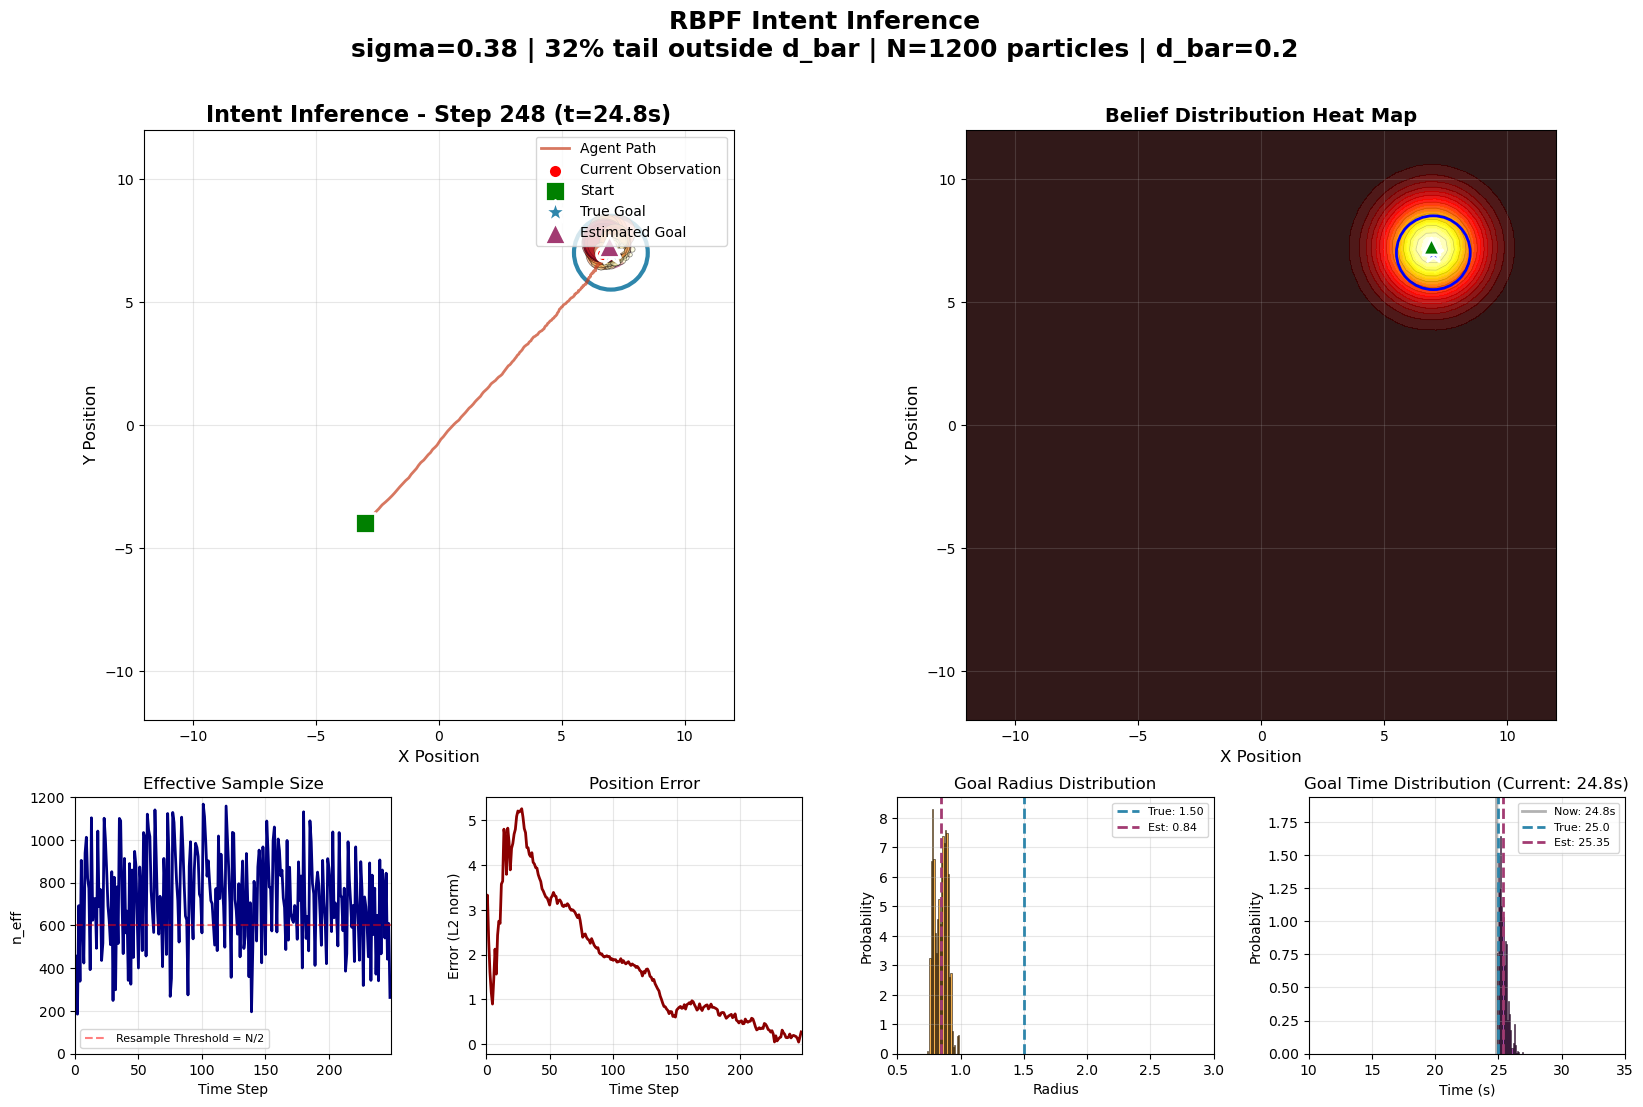


FINAL RESULTS
True Intent:      x=[7. 7.], r=1.50, t=25.0
Final Estimate:   x=[6.94126554 7.20731349], r=0.84, t=25.4
Final Time:       24.9s

Final Errors:
  Position: 0.215
  Radius:   0.657
  Time:     0.379


In [ ]:

def create_animated_inference(save_gif=True, save_mp4=False, filename_base='intent_inference', reference_type = 'line'):
    
    save_folder = 'figures'
    
    # Setup parameters
    theta_true = np.array([7.0, 7.0, 1.5, 25.0])  # [x, y, r, t]
    x0 = np.array([-3.0, -4.0])
    
    print(f"True Intent: x={theta_true[:2]}, r={theta_true[2]:.2f}, t={theta_true[3]:.1f}")
    print(f"Start Position: {x0}")
    
    # Create agent and filter
    agent = MultiModeAgent(theta_com=theta_true, x0=x0, mode=reference_type, d_bar=0.2, dt=0.1, amplitude=2.0, noise_type='random', noise_frequency=2, noise_phase=0)
    rbpf = PaperBasedRBPF(N=1200, R=12.0, r_min=0.5, r_max=3.0, t_min=10.0, t_max=35.0, d_bar=0.2, dt=0.1, err_std=0.1)

    # Run simulation to collect data
    T = 250
    observations = []
    
    print("\nRunning simulation with detailed tracking...")
    print("-" * 60)
    for t in range(T):
        x_true = agent.step()
        y = x_true + np.random.randn(2) * 0.1
        observations.append(y)
        rbpf.update(y)
        
        if t % 50 == 0 and t > 0:
            est = rbpf.get_estimate('reduced')
            print(f"Step {t:3d} | Time: {rbpf.current_time:5.1f}s | n_eff: {rbpf.compute_n_eff():4.0f}")
            print(f"  True:  x=[{theta_true[0]:5.2f}, {theta_true[1]:5.2f}], r={theta_true[2]:4.2f}, t={theta_true[3]:5.1f}")
            print(f"  Est:   x=[{est['x'][0]:5.2f}, {est['x'][1]:5.2f}], r={est['r']:4.2f}, t={est['t']:5.1f}")
            
            # Calculate errors
            err_x = np.linalg.norm(est['x'] - theta_true[:2])
            err_r = abs(est['r'] - theta_true[2])
            err_t = abs(est['t'] - theta_true[3])
            print(f"  Error: x={err_x:5.2f}, r={err_r:4.2f}, t={err_t:5.1f}")
            print("-" * 60)
    
    observations = np.array(observations)
    trajectory = np.array(agent.trajectory)
    
    print("Creating animation...")
    
    # Setup figure with custom layout
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(3, 4, figure=fig, hspace=0.3, wspace=0.3)
    
    # Main plots
    ax_main = fig.add_subplot(gs[:2, :2])  # Large main plot
    ax_heat = fig.add_subplot(gs[:2, 2:])   # Heat map
    
    # Bottom plots
    ax_neff = fig.add_subplot(gs[2, 0])     # n_eff
    ax_error = fig.add_subplot(gs[2, 1])    # Error
    ax_radius = fig.add_subplot(gs[2, 2])   # Radius distribution
    ax_time = fig.add_subplot(gs[2, 3])     # Time distribution
    
    # Color scheme
    colors = {
        'true': '#2E86AB',
        'estimate': '#A23B72',
        'particles': '#F18F01',
        'trajectory': '#C73E1D'
    }
    
    def init():
        """Initialize animation"""
        return []
    
    def animate(frame):
        """Animation function"""
        
        # Clear all axes
        for ax in [ax_main, ax_heat, ax_neff, ax_error, ax_radius, ax_time]:
            ax.clear()
        
        # Skip if no data yet
        if frame >= len(rbpf.history['particles']) or frame == 0:
            return []
        
        # Get current data
        particles = rbpf.history['particles'][frame]
        weights = rbpf.history['weights'][frame]
        n_eff = rbpf.history['n_eff'][frame]
        estimate = rbpf.history['estimates'][frame]
        current_time = frame * 0.1  # Current simulation time
        
        # ========== MAIN PLOT ==========
        ax_main.set_title(f'Intent Inference - Step {frame} (t={current_time:.1f}s)', 
                         fontsize=16, fontweight='bold')
        
        # Plot trajectory up to current time
        ax_main.plot(trajectory[:frame+1, 0], trajectory[:frame+1, 1],
                    color=colors['trajectory'], linewidth=2, alpha=0.7,
                    label='Agent Path')
        
        # Current observation
        ax_main.scatter(observations[frame, 0], observations[frame, 1],
                       c='red', s=100, zorder=5, marker='o',
                       edgecolors='white', linewidth=2,
                       label='Current Observation')
        
        # Start and goal
        ax_main.scatter(x0[0], x0[1], c='green', s=200, marker='s',
                       edgecolors='white', linewidth=2,
                       label='Start', zorder=5)
        ax_main.scatter(theta_true[0], theta_true[1], 
                       color=colors['true'], s=300, marker='*',
                       edgecolors='white', linewidth=2,
                       label='True Goal', zorder=5)
        
        # True goal region
        circle_true = Circle(theta_true[:2], theta_true[2],
                            fill=False, edgecolor=colors['true'], 
                            linewidth=3, linestyle='-')
        ax_main.add_patch(circle_true)
        
        # Estimated goal
        ax_main.scatter(estimate['x'][0], estimate['x'][1],
                       color=colors['estimate'], s=250, marker='^',
                       edgecolors='white', linewidth=2,
                       label='Estimated Goal', zorder=5)
        
        # Estimated goal region
        circle_est = Circle(estimate['x'], estimate['r'],
                           fill=False, edgecolor=colors['estimate'],
                           linewidth=3, linestyle='--', alpha=0.7)
        ax_main.add_patch(circle_est)
        
        # Plot particles (only significant ones)
        mask = weights > 1e-4
        if np.any(mask):
            sizes = 1000 * weights[mask] / np.max(weights[mask])
            ax_main.scatter(particles[mask, 0], particles[mask, 1],
                          c=weights[mask], s=sizes,
                          cmap='YlOrRd', alpha=0.5,
                          edgecolors='black', linewidth=0.5)
        
        ax_main.set_xlim(-rbpf.R, rbpf.R)
        ax_main.set_ylim(-rbpf.R, rbpf.R)
        ax_main.set_xlabel('X Position', fontsize=12)
        ax_main.set_ylabel('Y Position', fontsize=12)
        ax_main.legend(loc='upper right', fontsize=10)
        ax_main.grid(True, alpha=0.3)
        ax_main.set_aspect('equal')
        
        # ========== HEAT MAP ==========
        ax_heat.set_title('Belief Distribution Heat Map', fontsize=14, fontweight='bold')
        
        # Create grid
        resolution = 60
        x_range = np.linspace(-rbpf.R, rbpf.R, resolution)
        y_range = np.linspace(-rbpf.R, rbpf.R, resolution)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.zeros_like(X)
        
        # Accumulate Gaussian contributions
        for i in range(len(particles)):
            if weights[i] > 1e-6:
                x_i, y_i = particles[i, :2]
                r_i = particles[i, 2]
                
                # Gaussian contribution
                contrib = weights[i] * np.exp(
                    -((X - x_i)**2 + (Y - y_i)**2) / (2 * (r_i + 0.5)**2)
                )
                Z += contrib
        
        # Normalize
        if np.max(Z) > 0:
            Z = Z / np.max(Z)
        
        # Plot heat map
        im = ax_heat.contourf(X, Y, Z, levels=20, cmap='hot', alpha=0.9)
        ax_heat.contour(X, Y, Z, levels=10, colors='black', alpha=0.2, linewidths=0.5)
        
        # Add true goal
        ax_heat.scatter(theta_true[0], theta_true[1],
                       color='blue', s=200, marker='*',
                       edgecolors='white', linewidth=2, zorder=5)
        circle_true_heat = Circle(theta_true[:2], theta_true[2],
                                fill=False, edgecolor='blue',
                                linewidth=2, linestyle='-')
        ax_heat.add_patch(circle_true_heat)
        
        # Add estimated goal
        ax_heat.scatter(estimate['x'][0], estimate['x'][1],
                       color='green', s=150, marker='^',
                       edgecolors='white', linewidth=2, zorder=5)
        
        ax_heat.set_xlim(-rbpf.R, rbpf.R)
        ax_heat.set_ylim(-rbpf.R, rbpf.R)
        ax_heat.set_xlabel('X Position', fontsize=12)
        ax_heat.set_ylabel('Y Position', fontsize=12)
        ax_heat.set_aspect('equal')
        ax_heat.grid(True, alpha=0.2)
        
        # ========== N_EFF PLOT ==========
        ax_neff.set_title('Effective Sample Size', fontsize=12)
        ax_neff.plot(rbpf.history['n_eff'][:frame+1], 
                    color='navy', linewidth=2)
        ax_neff.axhline(rbpf.N/2, color='red', linestyle='--', 
                       alpha=0.5, label='Resample Threshold = N/2')
        ax_neff.set_xlabel('Time Step')
        ax_neff.set_ylabel('n_eff')
        ax_neff.set_xlim(0, len(rbpf.history['n_eff']))
        ax_neff.set_ylim(0, rbpf.N)
        ax_neff.grid(True, alpha=0.3)
        ax_neff.legend(fontsize=8)
        
        # ========== ERROR PLOT ==========
        ax_error.set_title('Position Error', fontsize=12)
        
        # Calculate errors over time
        errors = []
        for est in rbpf.history['estimates'][:frame+1]:
            err = np.linalg.norm(est['x'] - theta_true[:2])
            errors.append(err)
        
        ax_error.plot(errors, color='darkred', linewidth=2)
        ax_error.set_xlabel('Time Step')
        ax_error.set_ylabel('Error (L2 norm)')
        ax_error.set_xlim(0, len(rbpf.history['n_eff']))
        ax_error.grid(True, alpha=0.3)
        
        # ========== RADIUS DISTRIBUTION ==========
        ax_radius.set_title('Goal Radius Distribution', fontsize=12)
        ax_radius.hist(particles[:, 2], weights=weights, bins=25,
                      alpha=0.7, color=colors['particles'], density=True,
                      edgecolor='black', linewidth=0.5)
        ax_radius.axvline(theta_true[2], color=colors['true'],
                         linestyle='--', linewidth=2,
                         label=f'True: {theta_true[2]:.2f}')
        ax_radius.axvline(estimate['r'], color=colors['estimate'],
                         linestyle='--', linewidth=2,
                         label=f'Est: {estimate["r"]:.2f}')
        ax_radius.set_xlabel('Radius')
        ax_radius.set_ylabel('Probability')
        ax_radius.set_xlim(rbpf.r_min, rbpf.r_max)
        ax_radius.legend(fontsize=8)
        ax_radius.grid(True, alpha=0.3)
        
        # ========== TIME DISTRIBUTION ==========
        ax_time.set_title(f'Goal Time Distribution (Current: {current_time:.1f}s)', 
                         fontsize=12)
        
        # Filter out particles with invalid times (less than current time)
        valid_times = particles[:, 3]
        valid_weights = weights.copy()
        
        # Highlight current time
        ax_time.axvline(current_time, color='black', linestyle='-', 
                       linewidth=2, alpha=0.3, label=f'Now: {current_time:.1f}s')
        
        ax_time.hist(valid_times, weights=valid_weights, bins=25,
                    alpha=0.7, color='purple', density=True,
                    edgecolor='black', linewidth=0.5)
        ax_time.axvline(theta_true[3], color=colors['true'],
                       linestyle='--', linewidth=2,
                       label=f'True: {theta_true[3]:.1f}')
        ax_time.axvline(estimate['t'], color=colors['estimate'],
                       linestyle='--', linewidth=2,
                       label=f'Est: {estimate["t"]:.2f}')
        ax_time.set_xlabel('Time (s)')
        ax_time.set_ylabel('Probability')
        ax_time.set_xlim(rbpf.t_min, rbpf.t_max)
        ax_time.legend(fontsize=8)
        ax_time.grid(True, alpha=0.3)
        
        # Add frame counter
        fig.suptitle(f'RBPF Intent Inference\n'
                    f'sigma=0.38 | 32% tail outside d_bar | N={rbpf.N} particles | d_bar={rbpf.d_bar}',
                    fontsize=18, fontweight='bold', y=0.98)
        
        return []
    
    # Create animation
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames=len(rbpf.history['particles']),
                                 interval=50, blit=False)
    
    # Save animation
    if save_gif:
        print(f"Saving animation as {save_folder}/{filename_base + reference_type}.gif...")
        anim.save(f'{save_folder}/{filename_base + reference_type}.gif', writer='pillow', fps=20)
        print(f"Animation saved as {save_folder}/{filename_base + reference_type}.gif")
    
    if save_mp4:
        print(f"Saving animation as {save_folder}/{filename_base + reference_type}.mp4...")
        try:
            anim.save(f'{save_folder}/{filename_base + reference_type}.mp4', writer='ffmpeg', fps=20, 
                     bitrate=2000, codec='libx264')
            print(f"Animation saved as {save_folder}/{filename_base + reference_type}.mp4")
        except:
            print("MP4 save failed. Make sure ffmpeg is installed.")
    
    plt.show()
    
    # Print final results
    print("\n" + "=" * 60)
    print("FINAL RESULTS")
    print("=" * 60)
    
    final_estimate = rbpf.get_estimate('reduced')
    print(f"True Intent:      x={theta_true[:2]}, r={theta_true[2]:.2f}, t={theta_true[3]:.1f}")
    print(f"Final Estimate:   x={final_estimate['x']}, r={final_estimate['r']:.2f}, t={final_estimate['t']:.1f}")
    print(f"Final Time:       {rbpf.current_time:.1f}s")
    
    # Calculate final errors
    err_x = np.linalg.norm(final_estimate['x'] - theta_true[:2])
    err_r = abs(final_estimate['r'] - theta_true[2])
    err_t = abs(final_estimate['t'] - theta_true[3])
    
    print(f"\nFinal Errors:")
    print(f"  Position: {err_x:.3f}")
    print(f"  Radius:   {err_r:.3f}")
    print(f"  Time:     {err_t:.3f}")
    
    print("=" * 60)
    
    return anim, rbpf


if __name__ == "__main__":
    # Create and save animation
    for reference_type in ['line', 'sinusoid']:
    #for reference_type in ['sinusoid']:
        anim, rbpf = create_animated_inference(
            save_gif=True,      # Save as GIF
            save_mp4=False,     # Save as MP4
            filename_base='rbpf_intent_inference_',
            reference_type=reference_type
        )

# generate pdf

In [ ]:
def gif_to_pdfs(gif_path, output_folder=None):
    # Get GIF name without extension
    gif_name = Path(gif_path).stem
    
    # Create output folder
    if output_folder is None:
        output_folder = f"{gif_name}_pdfs"
    
    os.makedirs(output_folder, exist_ok=True)
    print(f"Created folder: {output_folder}")
    
    # Open GIF and extract frames
    with Image.open(gif_path) as gif:
        frames = []
        frame_count = 0
        
        try:
            while True:
                # Convert frame to RGB if it's not already
                frame = gif.copy()
                if frame.mode != 'RGB':
                    frame = frame.convert('RGB')
                frames.append(frame)
                frame_count += 1
                gif.seek(gif.tell() + 1)
        except EOFError:
            pass  # End of frames
    
    print(f"Extracted {frame_count} frames from {gif_name}")
    complete_pdf_path = os.path.join(output_folder, f"{gif_name}_complete.pdf")
    frames[0].save(complete_pdf_path, save_all=True, append_images=frames[1:])
    print(f"Saved complete PDF: {complete_pdf_path}")
'''    
    for i, frame in enumerate(frames):
        frame_pdf_path = os.path.join(output_folder, f"{gif_name}_frame_{i+1}.pdf")
        frame.save(frame_pdf_path, "PDF")
        print(f"Saved frame {i+1} PDF: {frame_pdf_path}")
    
    print(f"\nAll done! Check the '{output_folder}' folder for your PDFs.")'''

if __name__ == "__main__":
    # Replace with your GIF file path
    gif_file = "./figures/line.gif"
    gif_to_pdfs(gif_file, "dynamics_line_dbar_1_sigma_0.28_5outside")